In [ ]:
!pip install cython pyyaml==5.1

     |████████████████████████████████| 276kB 3.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=9abcb4c9089938c549d3111f5b4b057a741e8ebdeebefff9098bb93d168abdb5
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html


Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 534kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200704-cp36-none-any.whl size=41894 sha256=f2c1629d40330b0f546d8c4a889cd7d9c45bc918cf753da6da0a15acd1cb1968
  Stored in directory: /root/.cache/pip/wheels/fb/d2/8e/b6d0f19811e77dabff1ebed6605ce2b59ee9f487079b434c8c
Successfully built fvcore


In [ ]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
%%time
!rm -r frames/*
!mkdir frames/

#specify path to video
video = "/content/NVR_ch9_main_20200619091000_20200619092507_1.dav"

#capture video
cap = cv2.VideoCapture(video)
cnt=0

# Check if video file is opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

ret,first_frame = cap.read()

#Read until video is completed
while(cap.isOpened()):
    
  # Capture frame-by-frame
  ret, frame = cap.read()
     
  if ret == True:

    #save each frame to folder        
    cv2.imwrite('frames/'+str(cnt)+'.png', frame)
    cnt=cnt+1
  else: 
    break

rm: cannot remove 'frames/*': No such file or directory


In [ ]:
print(cnt)

In [ ]:
#frame rate of a video
FPS=cap.get(cv2.CAP_PROP_FPS)
print(FPS)

20.0


In [ ]:
cfg = get_cfg()

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9  # set threshold for this model

# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_3x.yaml")
predictor = DefaultPredictor(cfg)

In [ ]:
#read an image
img = cv2.imread("frames/30.png")

#pass to the model
outputs = predictor(img)

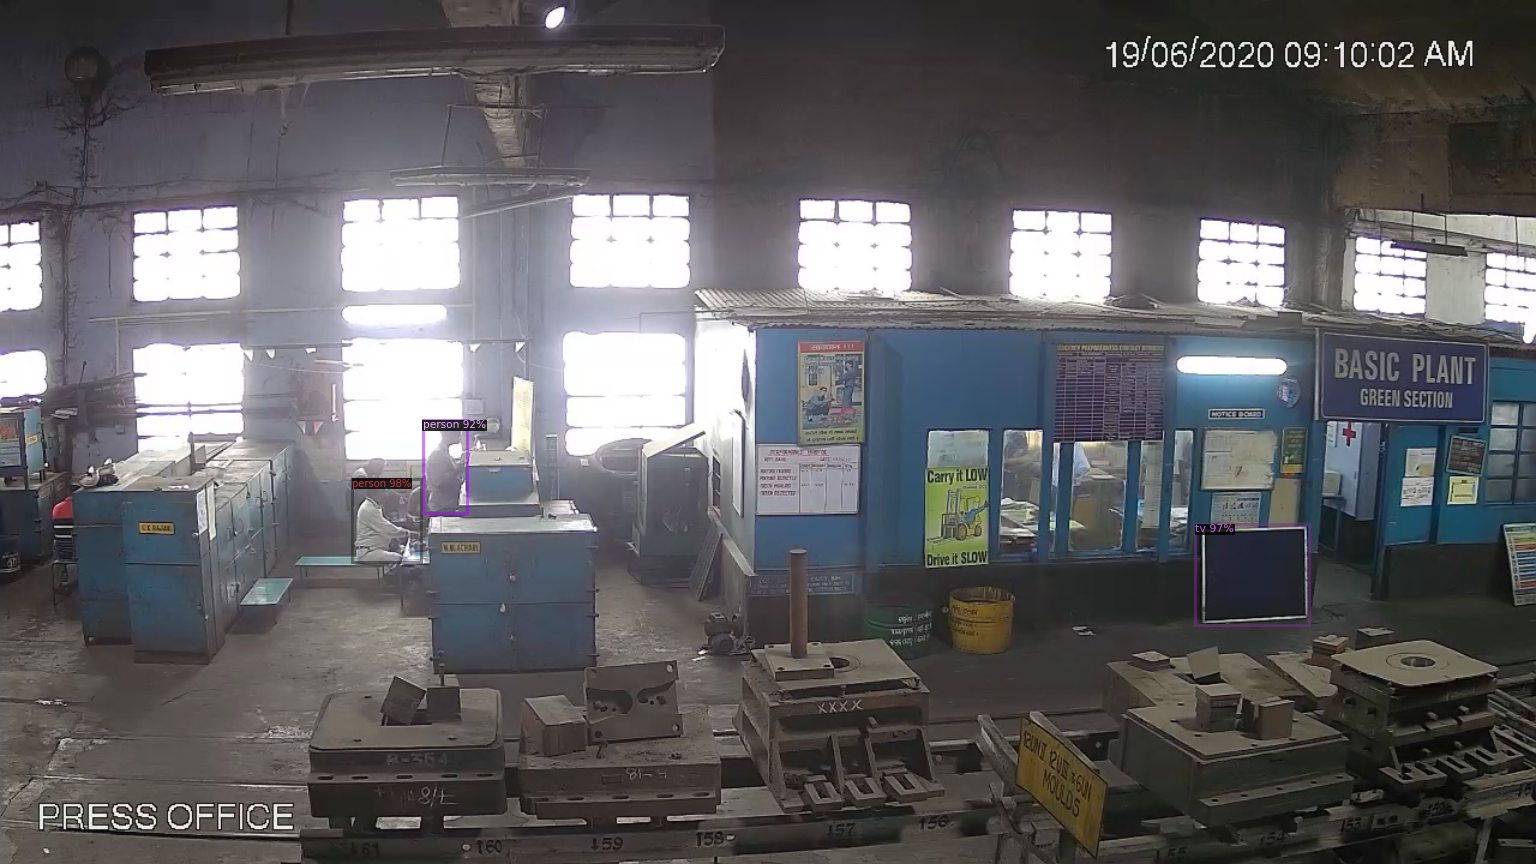

In [ ]:
# Use `Visualizer` to draw the predictions on the image.
v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
classes=outputs['instances'].pred_classes.cpu().numpy()
print(classes)

[ 0 62  0]


In [ ]:
bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
print(bbox)

[[ 293.73373  399.22827  351.03458  468.85382]
 [ 996.1462   437.34937 1090.6436   521.2521 ]
 [ 352.63953  350.85956  388.88138  427.717  ]]


In [ ]:
#identity only persons 
ind = np.where(classes==0)[0]

#identify bounding box of only persons
person=bbox[ind]

#total no. of persons
num= len(person)

In [ ]:

x1,y1,x2,y2 = person[0]
print(x1,y1,x2,y2)

293.73373 399.22827 351.03458 468.85382


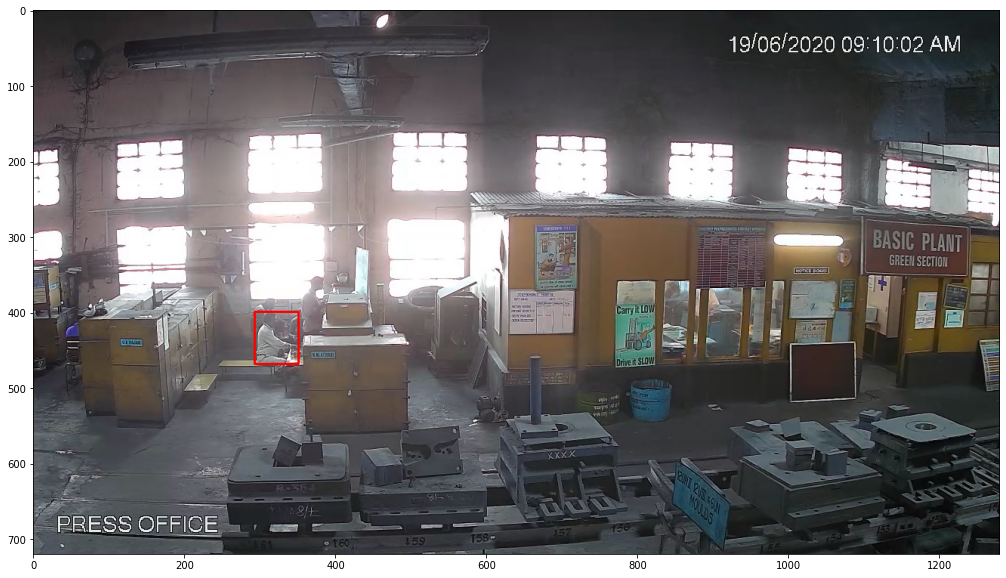

In [ ]:
img = cv2.imread('frames/30.png')
_ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

plt.figure(figsize=(20,10))
plt.imshow(img)

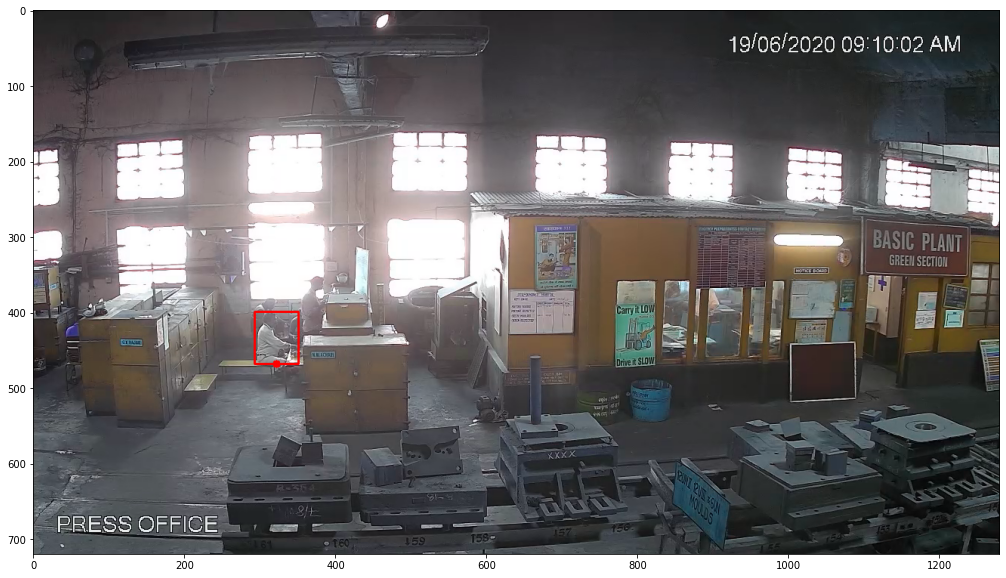

In [ ]:
#compute center 
x_center = int((x1+x2)/2)
y_center = int(y2)

center = (x_center, y_center)

_ = cv2.circle(img, center, 5, (255, 0, 0), -1)
plt.figure(figsize=(20,10))
plt.imshow(img)

In [ ]:
#define a function which return the bottom center of every bbox
def mid_point(img,person,idx):
  #get the coordinates
  x1,y1,x2,y2 = person[idx]
  _ = cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 2)
  
  #compute bottom center of bbox
  x_mid = int((x1+x2)/2)
  y_mid = int(y2)
  mid   = (x_mid,y_mid)
  
  _ = cv2.circle(img, mid, 5, (0, 0, 255), -1)
  cv2.putText(img, str(idx), mid, cv2.FONT_HERSHEY_SIMPLEX,1, (255, 255, 255), 2, cv2.LINE_AA)
  
  return mid

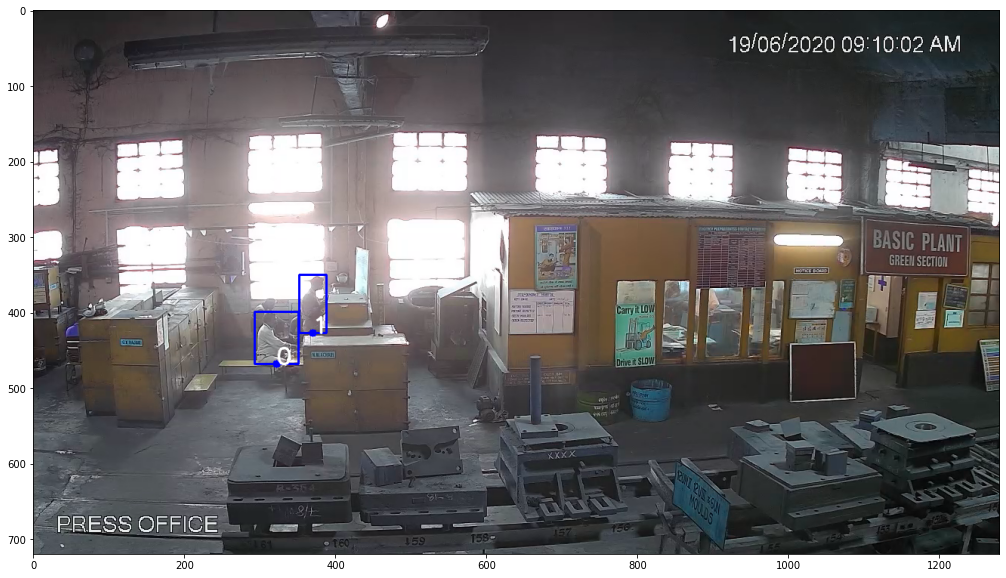

In [ ]:
#call the function
midpoints = [mid_point(img,person,i) for i in range(len(person))]

#visualize image
plt.figure(figsize=(20,10))
plt.imshow(img)

In [ ]:
%%time
from scipy.spatial import distance
def compute_distance(midpoints,num):
  dist = np.zeros((num,num))
  for i in range(num):
    for j in range(i+1,num):
      if i!=j:
        dst = distance.euclidean(midpoints[i], midpoints[j])
        dist[i][j]=dst
  return dist

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 24.3 µs


In [ ]:

dist= compute_distance(midpoints,num)

In [ ]:
%%time
def find_closest(dist,num,thresh):
  p1=[]
  p2=[]
  d=[]
  for i in range(num):
    for j in range(i,num):
      if( (i!=j) & (dist[i][j]<=thresh)):
        p1.append(i)
        p2.append(j)
        d.append(dist[i][j])
  return p1,p2,d

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11.2 µs


In [ ]:
import pandas as pd

thresh=100
p1,p2,d=find_closest(dist,num,thresh)
df = pd.DataFrame({"p1":p1,"p2":p2,"dist":d})
df

p1  p2       dist
0   0   1  63.126856

In [ ]:
def change_2_red(img,person,p1,p2):
  risky = np.unique(p1+p2)
  for i in risky:
    x1,y1,x2,y2 = person[i]
    _ = cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)  
  return img

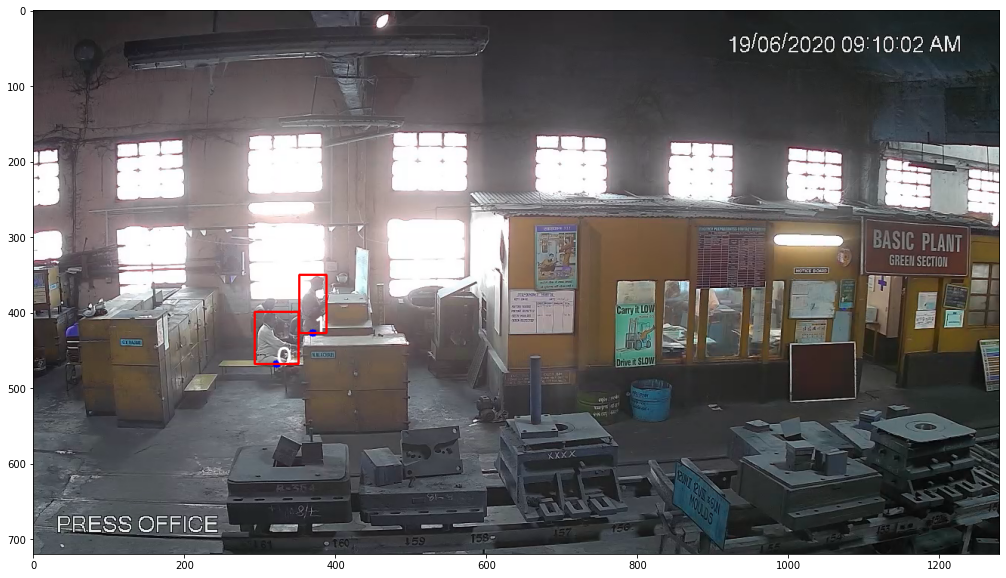

In [ ]:
img = change_2_red(img,person,p1,p2)

plt.figure(figsize=(20,10))
plt.imshow(img)

In [ ]:

import os
import re

names=os.listdir('frames/')
names.sort(key=lambda f: int(re.sub('\D', '', f)))

In [ ]:
def find_closest_people(name,thresh):

  img = cv2.imread('frames/'+name)
  outputs = predictor(img)
  classes=outputs['instances'].pred_classes.cpu().numpy()
  bbox=outputs['instances'].pred_boxes.tensor.cpu().numpy()
  ind = np.where(classes==0)[0]
  person=bbox[ind]
  midpoints = [mid_point(img,person,i) for i in range(len(person))]
  num = len(midpoints)
  dist= compute_distance(midpoints,num)
  p1,p2,d=find_closest(dist,num,thresh)
  img = change_2_red(img,person,p1,p2)
  cv2.imwrite('frames/'+name,img)
  return 0

In [ ]:
from tqdm import tqdm
thresh=100
_ = [find_closest_people(names[i],thresh) for i in tqdm(range(len(names))) ]

 19%|█▊        | 3387/18151 [1:01:54<4:33:32,  1.11s/it]

In [ ]:
%%time
frames = os.listdir('frames/')
frames.sort(key=lambda f: int(re.sub('\D', '', f)))

frame_array=[]

for i in range(len(frames)):
    
    #reading each files
    img = cv2.imread('frames/'+frames[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    height, width, layers = img.shape
    size = (width,height)
    
    #inserting the frames into an image array
    frame_array.append(img)

out = cv2.VideoWriter('sample_output.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 20, size)
 
for i in range(len(frame_array)):
    # writing to a image array
    out.write(frame_array[i])
out.release()